# Análise de Betas do Mercado Acionário Brasileiro

Segue uma análise exploratória dos Betas estimados das ações no mercado acionário brasileiro utilizando a linguagem de programação Python. Optamos por segmentar cada empresa de acordo com seu setor, com o objetivo de examinar as distribuições de seus riscos de mercado. Adicionalmente, elaboramos classificações de portfólio com base na alocação de betas elevados e baixos, a fim de avaliar a eficácia da estratégia proposta pelo Modelo de Precificação de Ativos de Capital (CAPM). Isso nos permitiu realizar um teste de excesso de retorno e traçar a Security Market Line como parte da avaliação da formulação proposta.

## Beta

De acordo com o Modelo de Precificação de Ativos de Capital (CAPM) de Sharpe (1964), Lintner (1965) e Mossin (1966), a variação transversal nas taxas de retorno esperadas dos ativos deve ser uma função da covariância entre o excesso de retorno do ativo e o excesso de retorno do portfólio de mercado. O coeficiente de regressão dos excessos de retornos de mercado nos excessos de retornos de ações é geralmente chamado de beta de mercado. Não entramos em detalhes sobre os fundamentos do beta de mercado, mas simplesmente remetemos a qualquer tratamento do CAPM para mais informações. Em vez disso, fornecemos detalhes sobre todas as funções que usamos para calcular os resultados. Em particular, aproveitamos conceitos computacionais úteis: estimação com janela deslizante e classificação de portfólios.

Para estimar os coeficientes de regressão do CAPM

$$r_{i, t} - r_{f, t} = \alpha_i + \beta_i(r_{m, t}-r_{f,t})+\varepsilon_{i, t}$$

## Dados

Para o conjunto de amostra utilizamos dados de retornos diários de empresas participantes do Índice Bovespa. A lista de empresas foi obtida a partir da composição do Índice Bovespa no dia 10/07, que também inclui a separação por setores econômicos. Para o retorno livre de risco utilizamos o CDI diário. Os dados compreendem o período de 2023 até 07/2025.

# 1. Carregamento de bibliotecas

In [ ]:
# Instala bibliotecas
!pip install pyjanitor --quiet
!pip install unidecode --quiet
!pip install python-bcb --quiet
!pip install regtabletotext --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
# Carrega bibliotecas
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from plotnine import *
import seaborn as sns
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format
import yfinance as yf
import janitor
from unidecode import unidecode
from bcb import sgs
from regtabletotext import prettify_result
from google.colab import drive
import pandas as pd
import janitor  # garante que .clean_names() funcione
from unidecode import unidecode

# 2. Coleta e Tratamento de dados

## 2.1 Composição do Índice Bovespa

In [ ]:
# Monta o Google Drive
drive.mount('/content/drive')

# Caminho para o arquivo CSV
file_path = '/content/drive/MyDrive/IBOVDia_14-07-25.csv'

Mounted at /content/drive


In [ ]:
# Lê o arquivo CSV do caminho especificado, pulando a primeira linha e definindo o separador como ';' e a codificação como 'latin1'
symbols = (
     pd.read_csv('/content/drive/MyDrive/IBOVDia_14-07-25.csv',
                skiprows=1, sep=';', encoding='latin1', decimal = ',', index_col = False)
    # Filtra as linhas onde a coluna 'Ação' não é um valor NA
    .loc[lambda x: ~x['Ação'].isna()]
    # Usa o Pyjanitor para renomear as colunas, tornando-as mais limpas
    .clean_names()
     .query('codigo not in ["ALOS3", "ARZZ3", "SOMA3", "CIEL3", "RRRP3"]')
    # Atribui novos valores à coluna 'codigo' e 'tickers' usando funções lambda
    .assign(tickers = lambda x: x.codigo + '.SA',
            # Divide a coluna 'setor' em '/' e mantém a primeira parte (antes do primeiro '/')
            setor = lambda x: x.setor.str.split('/').str[0].str.strip(),
            qtde_teorica = lambda x: x.qtde_teorica.str.replace('.', '').astype(float))
    # Seleciona apenas as colunas 'setor', 'tickers' e 'qtde_teorica' no DataFrame resultante
    [['setor', 'tickers', 'qtde_teorica']]
)

# Função para limpar os nomes
def clean_name(name):
    # Remove acentos e transforma em minúsculas
    cleaned_name = unidecode(name).lower()
    # Remove espaços em branco
    cleaned_name = cleaned_name.replace(' ', '_')
    cleaned_name = cleaned_name.replace('.', '_')
    return cleaned_name

# Limpa os nomes dos setores
symbols = (
            symbols
            .assign(setor = lambda x : x.setor.apply(clean_name).replace({'financeiro_e_outros' : 'financ_e_outros',
                                                                         'cons_n__basico' : 'cons_n_basico'})
            )
            )

symbols

,setor,tickers,qtde_teorica
0,bens_indls,WEGE3.SA,1.482106e+09
1,bens_indls,EMBR3.SA,7.346317e+08
2,bens_indls,POMO4.SA,6.663784e+08
3,bens_indls,MOTV3.SA,9.919209e+08
4,bens_indls,RAIL3.SA,1.216914e+09
...,...,...,...
79,utilidade_publ,ENEV3.SA,1.907494e+09
80,utilidade_publ,EGIE3.SA,2.552369e+08
81,utilidade_publ,EQTL3.SA,1.244305e+09
82,utilidade_publ,ISAE4.SA,3.958010e+08


In [ ]:
## acerto para colocar em milhares a qtde_teorica

symbols.style.format({'qtde_teorica': '{:,.0f}'})

,setor,tickers,qtde_teorica
0,bens_indls,WEGE3.SA,"1,482,105,837"
1,bens_indls,EMBR3.SA,"734,631,701"
2,bens_indls,POMO4.SA,"666,378,439"
3,bens_indls,MOTV3.SA,"991,920,937"
4,bens_indls,RAIL3.SA,"1,216,914,397"
5,bens_indls,STBP3.SA,"409,543,219"
6,cons_n_basico,BRFS3.SA,"832,617,717"
7,cons_n_basico,MRFG3.SA,"237,618,211"
8,cons_n_basico,BEEF3.SA,"433,214,256"
9,cons_n_basico,SMTO3.SA,"128,130,966"


In [ ]:
# Verifica se há setores únicos
symbols.setor.unique()

array(['bens_indls', 'cons_n_basico', 'cons_n_ciclico', 'consumo_ciclico',
       'diversos', 'financ_e_outros', 'mats_basicos', 'petroleo', 'saude',
       'tec_informacao', 'telecomunicacao', 'utilidade_publ'],
      dtype=object)

## 2.2 Coleta preços e calcula retornos

In [ ]:
# Lista de tickers de ações
tickers = symbols['tickers'].values.tolist() + ['^BVSP']

def create_returns(assets, start, end, max_nan_ratio=0.05):
    # Baixa os dados
    precos_ativos = yf.download(assets, start=start, end=end, ignore_tz=True, auto_adjust=False)

    # Seleciona apenas 'Adj Close' e ajusta colunas
    precos_ativos = precos_ativos.loc[:, ('Adj Close', slice(None))]
    precos_ativos.columns = assets

    # Preenche valores faltantes com último valor válido (forward fill)
    precos_ativos_ffill = precos_ativos.fillna(method='ffill')

    # Remove ativos com mais de max_nan_ratio % de dados faltantes
    nan_ratio = precos_ativos.isna().mean()
    ativos_validos = nan_ratio[nan_ratio <= max_nan_ratio].index.tolist()

    precos_ativos_ffill = precos_ativos_ffill[ativos_validos]

    # Calcula retornos simples
    retornos = precos_ativos_ffill.pct_change().dropna()

    return retornos


In [ ]:
returns = create_returns(tickers, start='2023-01-03', end='2025-07-10')
print(returns.shape)


[*********************100%***********************]  84 of 84 completed
/tmp/ipython-input-82-2202558028.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


(626, 82)


## 2.3 Coleta Taxa livre de risco (CDI)

In [ ]:
# Coleta o cdi
cdi = sgs.get({'rf' : 12}, start = '2023-01-01', end = '2025-07-10').div(100)

# Junta cdi com retornos
all_returns = returns.join(cdi)

# Subtrai o valor da coluna 'rf' de todas as colunas numéricas
all_returns_excess = all_returns.apply(lambda x: x - all_returns['rf'] if pd.api.types.is_numeric_dtype(x) else x, axis = 0)

# Excesso de retorno
all_returns_excess

,WEGE3.SA,EMBR3.SA,POMO4.SA,MOTV3.SA,RAIL3.SA,STBP3.SA,BRFS3.SA,MRFG3.SA,BEEF3.SA,SMTO3.SA,...,ELET3.SA,ELET6.SA,ENGI11.SA,ENEV3.SA,EGIE3.SA,EQTL3.SA,ISAE4.SA,TAEE11.SA,^BVSP,rf
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.005138,0.024747,0.019183,0.022469,0.007093,0.012360,0.008257,0.002349,0.004438,0.037580,...,0.019636,0.001285,0.024150,0.028945,0.004455,0.021365,0.006222,0.012578,0.010705,0.0
2023-01-05,0.002299,-0.005749,0.004320,0.011471,0.030507,0.045167,0.031878,0.042939,0.001645,0.020569,...,0.058731,0.016271,0.024448,0.004260,0.009369,0.026386,0.001631,0.012409,0.020226,0.0
2023-01-06,0.001591,0.002653,0.000178,0.019132,0.023069,0.013377,0.026271,0.027479,0.028651,0.014018,...,0.010145,0.015334,0.036884,0.006272,0.028832,0.020871,0.014167,0.035624,0.011751,0.0
2023-01-09,0.005079,0.009471,-0.016969,-0.010666,-0.014011,-0.010208,0.001848,0.012161,0.004264,0.005521,...,0.003445,0.000575,0.014580,-0.009262,0.000917,-0.003648,-0.003400,-0.011790,0.003085,0.0
2023-01-10,0.009214,0.000012,-0.010968,0.026681,0.034919,0.016490,0.020390,0.029506,0.014630,0.006983,...,0.036238,0.011824,0.049038,0.011041,0.057841,0.009991,-0.010265,0.012978,0.014919,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-03,-0.013006,0.016314,0.019036,0.036841,0.011213,0.013546,0.020695,0.023287,0.006069,0.023497,...,0.020282,-0.005253,0.017170,0.026047,0.020133,0.019766,0.006048,0.019178,0.012947,0.0
2025-07-04,0.002416,0.004327,-0.009651,0.000179,0.005605,0.005278,-0.001245,-0.005327,-0.000003,0.011190,...,0.013054,0.002356,-0.012989,0.026267,0.002765,0.007538,0.006239,-0.013248,0.003351,0.0
2025-07-07,-0.009427,0.003332,-0.024021,-0.020264,-0.004630,-0.017047,-0.012349,-0.010149,-0.012055,0.011054,...,-0.018448,-0.015225,0.017081,-0.024456,-0.013038,-0.009502,-0.016133,-0.025046,-0.014603,0.0


In [ ]:
# Remove a coluna 'rf'
all_returns_excess = all_returns_excess.drop(columns = ['rf']).rename({'^BVSP' : 'market'}, axis = 1)

# Transforma de wide para long
all_returns_excess_long = all_returns_excess.melt(id_vars = 'market', var_name = 'tickers', value_name = 'returns', ignore_index = False)

# Exibe os retornos em excesso em formato long
all_returns_excess_long

,market,tickers,returns
Date,,,
2023-01-04,0.010705,WEGE3.SA,0.005138
2023-01-05,0.020226,WEGE3.SA,0.002299
2023-01-06,0.011751,WEGE3.SA,0.001591
2023-01-09,0.003085,WEGE3.SA,0.005079
2023-01-10,0.014919,WEGE3.SA,0.009214
...,...,...,...
2025-07-03,0.012947,TAEE11.SA,0.019178
2025-07-04,0.003351,TAEE11.SA,-0.013248
2025-07-07,-0.014603,TAEE11.SA,-0.025046


# 3. Estimação de Beta

A estimativa do Beta diário móvel oferece a capacidade de avaliar a evolução e alteração da relação entre a ação/setores e o risco de mercado ao longo do tempo. Isso é alcançado ao excluir valores mais antigos que poderiam distorcer a contemporaneidade da relação de risco.

Além disso, ao examinar o Beta como uma Série Temporal para cada empresa, a oportunidade de agrupá-las por setores surge como uma abordagem valiosa. Isso possibilita a identificação de padrões e distribuições na relação de cada setor com o risco de mercado em um período específico, oferecendo insights mais abrangentes.

## 3.1 Estima o Beta diário Móvel

In [ ]:
# Define função para calcular o beta móvel das ações
def roll_capm_estimation(data, window_size, min_obs):

    # Calcula a regressão linear com janela deslizante usando o método RollingOLS
    result = (RollingOLS.from_formula(
      formula = "returns ~ market",  # Fórmula da regressão linear
      data = data,                    # Dados utilizados
      window = window_size,           # Tamanho da janela deslizante
      min_nobs = min_obs               # Número mínimo de observações necessárias
      )
      .fit()                           # Ajusta o modelo de regressão
      .params["market"]                # Obtém o parâmetro beta associado à variável 'market'
    )

    # Ajusta o índice do resultado para coincidir com o índice dos dados originais
    result.index = data.index

    # Converte o resultado para um DataFrame com o nome da coluna 'beta'
    result = pd.DataFrame(result).rename({'market' : 'beta'}, axis = 1)

    # Retorna o resultado final
    return result






In [ ]:
# Estima os betas diários de todas as ações obtidas
beta = (
  all_returns_excess_long                          # DataFrame contendo retornos em excesso para todas as ações
  .groupby(["tickers"], group_keys = False)        # Agrupa os dados por 'tickers' sem adicionar chaves ao índice
  .apply(
    lambda x: x.assign(
      beta = roll_capm_estimation(x, window_size = 60, min_obs = 48)  # Calcula o beta usando a função roll_capm_estimation
    )
  )
  .dropna()                                        # Remove linhas com valores ausentes (NaN)
)

# Exibe o DataFrame resultante contendo os betas diários
beta



/tmp/ipython-input-87-3132755142.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,market,tickers,returns,beta
Date,,,,
2023-03-30,0.018354,ABEV3.SA,0.042012,1.842182
2023-03-31,-0.018162,ABEV3.SA,-0.011082,1.778961
2023-04-03,-0.004198,ABEV3.SA,-0.001017,1.764837
2023-04-04,0.003068,ABEV3.SA,0.029024,1.805310
2023-04-05,-0.009254,ABEV3.SA,0.016802,1.783701
...,...,...,...,...
2025-07-03,0.012947,YDUQ3.SA,0.017254,0.786780
2025-07-04,0.003351,YDUQ3.SA,0.002327,0.809158
2025-07-07,-0.014603,YDUQ3.SA,-0.022410,0.880085


In [ ]:
all_returns_excess_long['tickers'].value_counts()




,count
tickers,
WEGE3.SA,626
EMBR3.SA,626
POMO4.SA,626
MOTV3.SA,626
RAIL3.SA,626
...,...
ENEV3.SA,626
EGIE3.SA,626
EQTL3.SA,626


## 3.2 Distribuição de Beta por Setores do Índice Bovespa

In [ ]:
# Junta dados do beta com símbolos (setores)
beta_industries = (
  beta                                     # DataFrame contendo os betas diários
  .merge(symbols, how="inner", on=["tickers"])  # Junta os dados do beta com os símbolos usando a coluna 'tickers'
  .dropna(subset="beta")                        # Remove linhas com valores ausentes (NaN) na coluna 'beta'
  .groupby(["setor","tickers"])["beta"]        # Agrupa os dados por setor e tickers, selecionando a coluna 'beta'
  .aggregate("mean")                            # Calcula a média dos betas para cada grupo
  .reset_index()                                # Reseta o índice
)

# Exibe o DataFrame resultante contendo os betas médios agrupados por setor e tickers
beta_industries

,setor,tickers,beta
0,bens_indls,EMBR3.SA,1.591152
1,bens_indls,MOTV3.SA,1.565113
2,bens_indls,POMO4.SA,0.635848
3,bens_indls,RAIL3.SA,1.606580
4,bens_indls,STBP3.SA,0.781571
...,...,...,...
76,utilidade_publ,ENGI11.SA,2.140168
77,utilidade_publ,EQTL3.SA,0.686083
78,utilidade_publ,ISAE4.SA,0.607127
79,utilidade_publ,SBSP3.SA,0.370367


In [ ]:
# Mediana dos valores do beta dos setores
industry_order = (
  beta_industries                            # DataFrame contendo os betas médios por setor e tickers
  .groupby("setor")["beta"]                  # Agrupa os dados por setor e seleciona a coluna 'beta'
  .aggregate("median")                       # Calcula a mediana dos betas para cada setor
  .sort_values()                             # Ordena os setores com base na mediana dos betas
  .index.tolist()                            # Obtém a lista de setores ordenados
)

### 3.2.1 Visualização: Boxplot

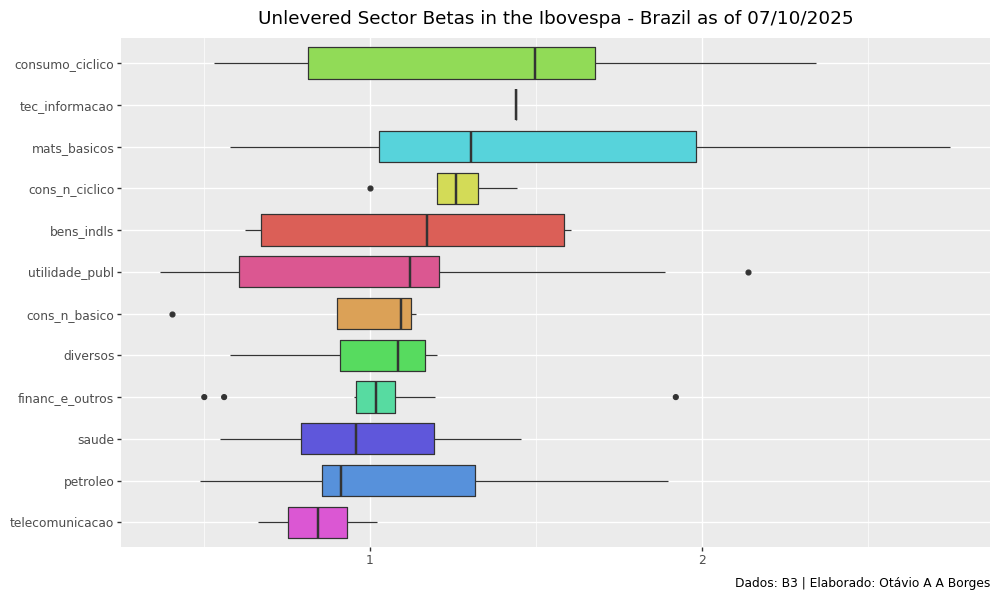

In [ ]:
plot_beta_industries = (
    ggplot(beta_industries, aes(x="setor", y="beta", fill="setor")) +  # fill para colorir por setor
    geom_boxplot() +
    coord_flip() +
    scale_x_discrete(limits=industry_order) +
    labs(
        x="",
        y="",
        title="Unlevered Sector Betas in the Ibovespa - Brazil as of 07/10/2025",
        caption="Dados: B3 | Elaborado: Otávio A A Borges"  # label no rodapé
    ) +
    theme(
        figure_size=(10, 6),
        legend_position="none"  # opcional: remove legenda se quiser
    )
)

plot_beta_industries.draw()


### 3.2.2 Visualização: Percentis

In [ ]:
# Obtém os percentis dos betas em diferentes datas
beta_quantiles = (
  beta                                       # DataFrame contendo os betas diários
  .groupby("Date")["beta"]                    # Agrupa os dados por data e seleciona a coluna 'beta'
  .quantile(q=np.arange(0.1, 1.0, 0.1))       # Calcula os percentis (de 0.1 a 0.9) dos betas para cada data
  .reset_index()                              # Reseta o índice
  .rename(columns={"level_1": "quantile"})    # Renomeia a coluna 'level_1' para 'quantile'
  .assign(
    quantile=lambda x: (x["quantile"] * 100).astype(int)  # Converte os percentis para inteiros (porcentagem)
  )
  .dropna()                                  # Remove linhas com valores ausentes (NaN)
)

# Exibe o DataFrame resultante contendo os percentis dos betas em diferentes datas
beta_quantiles

,Date,quantile,beta
0,2023-03-30,10,0.366894
1,2023-03-30,20,0.623012
2,2023-03-30,30,0.798639
3,2023-03-30,40,0.926725
4,2023-03-30,50,1.085124
...,...,...,...
5098,2025-07-09,50,1.090519
5099,2025-07-09,60,1.229653
5100,2025-07-09,70,1.332291
5101,2025-07-09,80,1.537984


/usr/local/lib/python3.11/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


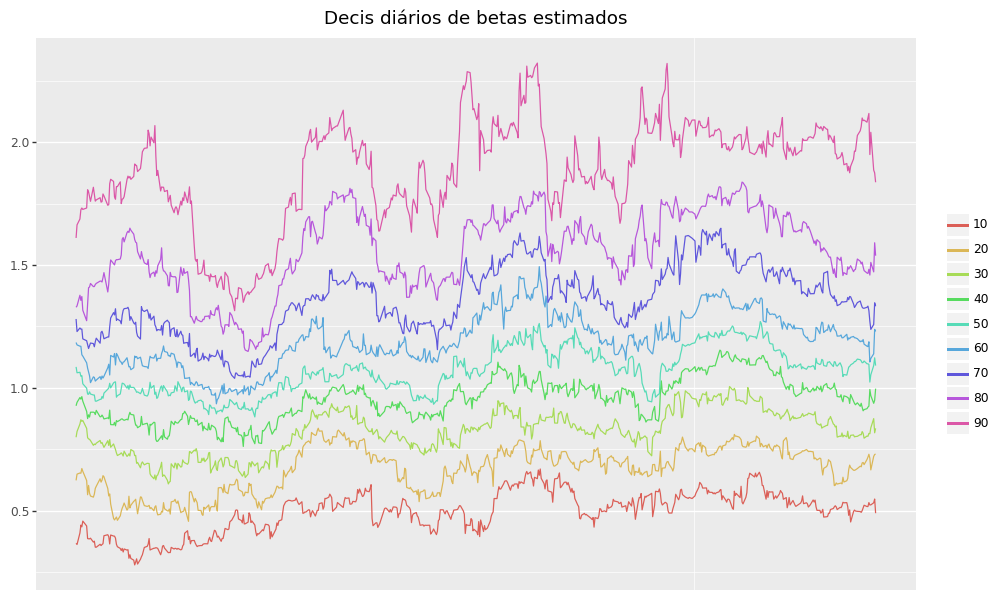

In [ ]:
# Plota os percentis em gráficos de linhas
plot_beta_quantiles = (
  ggplot(beta_quantiles,                       # DataFrame contendo os percentis dos betas em diferentes datas
         aes(x="Date", y="beta",
             color="factor(quantile)")) +     # Define as variáveis para o eixo x (Date), y (beta) e a cor (quantile)
  geom_line() +                               # Adiciona linhas ao gráfico
  scale_x_datetime(breaks=date_breaks("10 year"),  # Define intervalos de quebra no eixo x (aqui, a cada 10 anos)
                   labels=date_format("%Y")) +       # Formata os rótulos do eixo x como anos
  labs(x="", y="", color="",                   # Adiciona rótulos aos eixos x, y e à legenda de cores
       title="Decis diários de betas estimados") +  # Adiciona título ao gráfico
  theme(figure_size=(10, 6))
)

# Exibe o gráfico resultante
plot_beta_quantiles.draw()

### 3.2.3 Visualização: Matriz de correlação dos percentis

<Axes: xlabel='quantile', ylabel='quantile'>

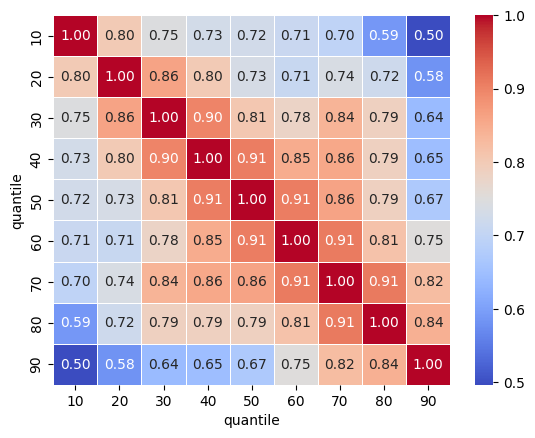

In [ ]:
# Calcula a correlação
correlation = beta_quantiles.pivot(index = 'Date', columns = 'quantile', values = 'beta').corr()

# Cria o heatmap
sns.heatmap(correlation, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5)

# 4. Classificação de Portfólios

Exploramos as classificações de portfólio, uma das metodologias estatísticas mais amplamente empregadas na análise empírica de ativos. A aplicação central das classificações de portfólio é avaliar se uma ou mais variáveis podem antecipar retornos futuros em excesso.

Em linhas gerais, a abordagem consiste em agrupar ações individuais em portfólios, nos quais as ações dentro de cada conjunto compartilham semelhanças em relação a uma variável específica, como tamanho da empresa, valor, risco de mercado (beta), entre outras. Os diversos portfólios representam investimentos bem diversificados que variam conforme o nível da variável de classificação. Ao analisar a distribuição resultante, torna-se possível atribuir as discrepâncias (diferenças) na distribuição de retornos ao impacto da variável de classificação. Isso é particularmente útil na criação de fatores de risco, especialmente aqueles que têm frequências trimestrais e semestrais.

Introduzimos classificações de portfólio univariadas, neste caso, utilizando o Beta como a característica principal.

Um classificação de portfólio univariada considera apenas uma variável de classificação $x_{t-1,i}$ . Aqui, $i$ denota a ação e $t-1$ indica que a característica é observável pelos investidores no momento $t$. O objetivo é avaliar a relação transversal entre $x_{t-1,i}$ e, tipicamente, os retornos em excesso da ação $r_{t,i}$ no momento $t$ como a variável dependente. Para ilustrar como as classificações de portfólio funcionam, utilizamos as estimativas para os betas de mercado como nossa variável de classificação. Um ponto importante, é que utilizamos os betas defasados de um período como variável de classificação para garantir que as classificações dependam apenas das informações disponíveis no momento em que criamos os portfólios.

Formulamos dois tipos diferentes de alocação para os portfólios: ponderados pelo percentual relativo na composição dos Ibovespa e outro igualmente ponderado.

In [ ]:
beta

,market,tickers,returns,beta
Date,,,,
2023-03-30,0.018354,ABEV3.SA,0.042012,1.842182
2023-03-31,-0.018162,ABEV3.SA,-0.011082,1.778961
2023-04-03,-0.004198,ABEV3.SA,-0.001017,1.764837
2023-04-04,0.003068,ABEV3.SA,0.029024,1.805310
2023-04-05,-0.009254,ABEV3.SA,0.016802,1.783701
...,...,...,...,...
2025-07-03,0.012947,YDUQ3.SA,0.017254,0.786780
2025-07-04,0.003351,YDUQ3.SA,0.002327,0.809158
2025-07-07,-0.014603,YDUQ3.SA,-0.022410,0.880085


In [ ]:
# Cria defasagem dos valores do beta
beta_lag = (
   beta                                       # DataFrame contendo os betas diários
  .reset_index()                              # Reseta o índice para transformar a data em uma coluna
  .assign(
    Date = lambda x: x["Date"] + pd.DateOffset(days=1)  # Adiciona um dia à data para criar uma defasagem
  )
  .rename(columns={"beta": "beta_lag"})      # Renomeia a coluna 'beta' para 'beta_lag'
  .dropna()                                  # Remove linhas com valores ausentes (NaN)
)

# Junta com os dados de símbolos e setores
data_for_sorts = (
  symbols                                    # DataFrame contendo dados de símbolos e setores
  .merge(beta_lag,                            # Junta os dados de beta_lag com os dados de símbolos
         how="inner",                          # Usa uma junção interna
         on=["tickers"])                       # Junta os dados usando a coluna 'tickers'
)
data_for_sorts

,setor,tickers,qtde_teorica,Date,market,returns,beta_lag
0,bens_indls,WEGE3.SA,1.482106e+09,2023-03-31,0.018354,0.000167,0.774911
1,bens_indls,WEGE3.SA,1.482106e+09,2023-04-01,-0.018162,-0.033571,0.821983
2,bens_indls,WEGE3.SA,1.482106e+09,2023-04-04,-0.004198,-0.000508,0.861750
3,bens_indls,WEGE3.SA,1.482106e+09,2023-04-05,0.003068,0.006471,0.879633
4,bens_indls,WEGE3.SA,1.482106e+09,2023-04-06,-0.009254,-0.002587,0.874588
...,...,...,...,...,...,...,...
45922,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-04,0.012947,0.019178,0.778935
45923,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-05,0.003351,-0.013248,0.836864
45924,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-08,-0.014603,-0.025046,0.840806
45925,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-09,-0.001892,-0.023778,0.788206


In [ ]:
# Computa os portfólios conforme beta baixos e altos
## Portfólio ponderado pela % no índice bovespa
beta_portfolios_comp = (
  data_for_sorts                               # DataFrame contendo dados de símbolos, setores e beta_lag
  .groupby("Date", group_keys=False)           # Agrupa os dados por data sem adicionar chaves ao índice
  .apply(lambda x: (
    x.assign(portfolio=pd.qcut(x["beta_lag"],  # Cria portfólios com base nos percentis dos betas
                               q=[0, 0.5, 1],
                               labels=["low", "high"])
    )
  ))
  .groupby(["portfolio", "Date"], group_keys=False)  # Agrupa por portfólio e data sem adicionar chaves ao índice
  .apply(lambda x: np.average(x["returns"],     # Calcula a média ponderada dos retornos para cada grupo
                              weights=x["qtde_teorica"]))
  .reset_index(name="ret")                       # Reseta o índice e renomeia a coluna de retornos
)

# Exibe o DataFrame resultante contendo os retornos dos portfólios ponderados
beta_portfolios_comp


/tmp/ipython-input-101-247967970.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipython-input-101-247967970.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipython-input-101-247967970.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after 

,portfolio,Date,ret
0,low,2023-03-31,0.015136
1,low,2023-04-01,-0.012602
2,low,2023-04-04,-0.004970
3,low,2023-04-05,0.012320
4,low,2023-04-06,-0.011852
...,...,...,...
1129,high,2025-07-04,0.019492
1130,high,2025-07-05,0.003096
1131,high,2025-07-08,-0.014979
1132,high,2025-07-09,-0.005989


In [ ]:
# Computa os portfólios conforme beta baixos e altos
## Portfólio igualmente ponderado
beta_portfolios_ewp = (
  data_for_sorts                               # DataFrame contendo dados de símbolos, setores e beta_lag
  .groupby("Date", group_keys=False)           # Agrupa os dados por data sem adicionar chaves ao índice
  .apply(lambda x: (
    x.assign(portfolio=pd.qcut(x["beta_lag"],  # Cria portfólios com base nos percentis dos betas
                               q=[0, 0.5, 1],
                               labels=["low", "high"])
    )
  ))
  .groupby(["portfolio", "Date"], group_keys=False)  # Agrupa por portfólio e data sem adicionar chaves ao índice
  .apply(lambda x: np.average(x["returns"]))    # Calcula a média ponderada dos retornos para cada grupo
  .reset_index(name="ret")                       # Reseta o índice e renomeia a coluna de retornos
)

# Exibe o DataFrame resultante contendo os retornos dos portfólios igualmente ponderados
beta_portfolios_ewp


/tmp/ipython-input-102-3773840652.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipython-input-102-3773840652.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipython-input-102-3773840652.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns aft

,portfolio,Date,ret
0,low,2023-03-31,0.010705
1,low,2023-04-01,-0.013258
2,low,2023-04-04,-0.006296
3,low,2023-04-05,0.010081
4,low,2023-04-06,-0.011580
...,...,...,...
1129,high,2025-07-04,0.018698
1130,high,2025-07-05,0.002339
1131,high,2025-07-08,-0.014032
1132,high,2025-07-09,-0.003979


## 4.1 Avaliação de performance dos portfólios

Podemos criar uma estratégia long-short com base nos dois portfólios: comprar o portfólio de alto beta e, ao mesmo tempo, fazer uma venda a descoberto no portfólio de baixa beta. Assim, a posição geral no mercado é zero líquido, ou seja, não é necessário investir dinheiro para realizar essa estratégia na ausência de atritos.





In [ ]:
# Diferença entre retornos de alto e baixo beta
## Portfólio ponderado pela % no índice bovespa
beta_longshort_comp = (
  beta_portfolios_comp                         # DataFrame contendo os retornos dos portfólios ponderados
  .pivot_table(index="Date",                   # Cria uma tabela dinâmica com datas como índice
               columns="portfolio",             # Usa os portfólios como colunas
               values="ret")                    # Seleciona os retornos como valores
  .reset_index()                               # Reseta o índice para transformar a data em uma coluna
  .assign(
    long_short=lambda x: x["high"] - x["low"]  # Calcula a diferença entre os retornos de alto e baixo beta
  )
)

# Exibe o DataFrame resultante contendo a diferença entre os retornos de alto e baixo beta
beta_longshort_comp

/tmp/ipython-input-103-2030831506.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


portfolio,Date,low,high,long_short
0,2023-03-31,0.015136,0.030646,0.015510
1,2023-04-01,-0.012602,-0.023436,-0.010834
2,2023-04-04,-0.004970,-0.019961,-0.014991
3,2023-04-05,0.012320,0.014637,0.002317
4,2023-04-06,-0.011852,-0.010719,0.001134
...,...,...,...,...
562,2025-07-04,0.008881,0.019492,0.010611
563,2025-07-05,0.004498,0.003096,-0.001402
564,2025-07-08,-0.005750,-0.014979,-0.009229
565,2025-07-09,0.000957,-0.005989,-0.006946


Calculamos o retorno médio e o erro padrão correspondente para testar se o portfólio long-short, em média, produz retornos em excesso positivos ou negativos. Na literatura de precificação de ativos, normalmente se ajusta para a autocorrelação usando as estatísticas de Newey e West (1987) para testar a hipótese nula de que os retornos médios em excesso do portfólio são iguais a zero.

In [ ]:
# Testa se o portfólio gera em média excesso de retorno positivo ou negativo
model_fit_comp = (
  sm.OLS.from_formula(
    formula="long_short ~ 1",                 # Fórmula da regressão linear
    data=beta_longshort_comp                   # DataFrame contendo os dados de long_short
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 12})  # Ajusta o modelo de regressão com correção HAC
)

# Exibe o resultado formatado da regressão
prettify_result(model_fit_comp)


OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept      -0.0       0.001       -0.145    0.884

Summary statistics:
- Number of observations: 567
- R-squared: 0.000, Adjusted R-squared: 0.000
- F-statistic not available



In [ ]:
# Diferença entre retornos de alto e baixo beta
## Portfólio ponderado igualmente
beta_longshort_ewp = (
  beta_portfolios_ewp                          # DataFrame contendo os retornos dos portfólios igualmente ponderados
  .pivot_table(index="Date",                   # Cria uma tabela dinâmica com datas como índice
               columns="portfolio",             # Usa os portfólios como colunas
               values="ret")                    # Seleciona os retornos como valores
  .reset_index()                               # Reseta o índice para transformar a data em uma coluna
  .assign(
    long_short=lambda x: x["high"] - x["low"]  # Calcula a diferença entre os retornos de alto e baixo beta
  )
)

# Exibe o DataFrame resultante contendo a diferença entre os retornos de alto e baixo beta
beta_longshort_ewp


/tmp/ipython-input-105-3801651867.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


portfolio,Date,low,high,long_short
0,2023-03-31,0.010705,0.033180,0.022475
1,2023-04-01,-0.013258,-0.024275,-0.011018
2,2023-04-04,-0.006296,-0.018135,-0.011839
3,2023-04-05,0.010081,0.007749,-0.002332
4,2023-04-06,-0.011580,-0.009182,0.002397
...,...,...,...,...
562,2025-07-04,0.011680,0.018698,0.007018
563,2025-07-05,0.002395,0.002339,-0.000056
564,2025-07-08,-0.009964,-0.014032,-0.004068
565,2025-07-09,-0.001809,-0.003979,-0.002170


In [ ]:
# Testa se o portfólio gera em média excesso de retorno positivo ou negativo
model_fit_ewp = (
  sm.OLS.from_formula(
    formula="long_short ~ 1",                 # Fórmula da regressão linear
    data=beta_longshort_ewp                    # DataFrame contendo os dados de long_short
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 12})                         # Ajusta o modelo de regressão com correção HAC
)

# Exibe o resultado formatado da regressão
prettify_result(model_fit_ewp)


OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept      -0.0       0.001       -0.048    0.962

Summary statistics:
- Number of observations: 567
- R-squared: -0.000, Adjusted R-squared: -0.000
- F-statistic not available



Os resultados indicam que não podemos rejeitar a hipótese nula de que os retornos médios são iguais a zero. Portanto, nossa estratégia de portfólio usando a mediana como ponto de corte não gera retornos anormais. Isso é surpreendente ao reconsiderar o CAPM? Certamente é. O CAPM sugere que as ações de alto beta devem proporcionar retornos esperados mais elevados. Nossa classificação de portfólio imita implicitamente uma estratégia de investimento que financia ações de alto beta ao realizar vendas a descoberto de ações de baixo beta. Portanto, seria de se esperar que os retornos médios em excesso resultassem em um retorno acima da taxa livre de risco.

# 5. Classificação de diversos portfólios

Vamos avançar na classificação de portfólio. Queremos ser capazes de classificar ações em um número arbitrário de portfólios. Para este caso, a programação funcional é muito útil: definimos uma função que nos dá flexibilidade em relação à variável a ser usada para a classificação. Definimos o ponto de quebra que desejamos para criar o número de portfólio desejados. Em seguida, atribuímos portfólios às ações.

Em algumas aplicações, a variável usada para a classificação pode estar agrupada (por exemplo, em um limite inferior de 0). Nesse caso, múltiplos pontos de quebra podem ser idênticos, levando a portfólios vazios. Da mesma forma, alguns portfólios podem ter um número muito pequeno de ações no início da amostra. Casos nos quais o número de constituintes do portfólio difere substancialmente devido à distribuição das características exigem consideração cuidadosa e, dependendo da aplicação, podem exigir abordagens de classificação personalizadas.

In [ ]:
# Cria função para otimizar a criação de portfólios
def assign_portfolio(data, sorting_variable, n_portfolios):
    # Calcula os pontos de corte com base na variável de ordenação
    breakpoints = np.quantile(
      data[sorting_variable].dropna(),          # Remove valores ausentes e calcula os percentis
      np.linspace(0, 1, n_portfolios + 1),      # Cria intervalos igualmente espaçados
      method="linear"
    )

    # Atribui rótulos aos portfólios com base nos pontos de corte
    assigned_portfolios = pd.cut(
      data[sorting_variable],                   # Variável de ordenação
      bins=breakpoints,                         # Pontos de corte
      labels=range(1, breakpoints.size),        # Rótulos para os portfólios
      include_lowest=True                       # Inclui o valor mais baixo no primeiro intervalo
    )

    return assigned_portfolios


In [ ]:
# Cria 10 portfólios conforme o beta
## Ponderação pela % na composição do Índice Bovespa
beta_portfolios = (
  data_for_sorts                               # DataFrame contendo dados de símbolos, setores e beta_lag
  .groupby("Date", group_keys=False)           # Agrupa os dados por data sem adicionar chaves ao índice
  .apply(lambda x: x.assign(
    portfolio=assign_portfolio(x, 'beta_lag', 10)  # Cria 10 portfólios com base no beta_lag
    )
  )
  .groupby(["portfolio", "Date"], group_keys=False)  # Agrupa por portfólio e data sem adicionar chaves ao índice
  .apply(lambda x: x.assign(
    ret=np.average(x["returns"], weights=x["qtde_teorica"])  # Calcula a média ponderada dos retornos para cada grupo
    )
  )
)

# Exibe o dataframe
beta_portfolios

/tmp/ipython-input-108-2967485589.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipython-input-108-2967485589.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipython-input-108-2967485589.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns aft

,setor,tickers,qtde_teorica,Date,market,returns,beta_lag,portfolio,ret
0,bens_indls,WEGE3.SA,1.482106e+09,2023-03-31,0.018354,0.000167,0.774911,3,0.011054
1,bens_indls,WEGE3.SA,1.482106e+09,2023-04-01,-0.018162,-0.033571,0.821983,3,-0.022397
2,bens_indls,WEGE3.SA,1.482106e+09,2023-04-04,-0.004198,-0.000508,0.861750,4,-0.000759
3,bens_indls,WEGE3.SA,1.482106e+09,2023-04-05,0.003068,0.006471,0.879633,4,-0.009979
4,bens_indls,WEGE3.SA,1.482106e+09,2023-04-06,-0.009254,-0.002587,0.874588,4,-0.020464
...,...,...,...,...,...,...,...,...,...
45922,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-04,0.012947,0.019178,0.778935,3,0.018039
45923,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-05,0.003351,-0.013248,0.836864,3,0.004402
45924,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-08,-0.014603,-0.025046,0.840806,3,-0.008122
45925,utilidade_publ,TAEE11.SA,2.185682e+08,2025-07-09,-0.001892,-0.023778,0.788206,3,-0.002672


## 5.2 Visualização: Alpha dos Portfólios Classificados

No próximo passo, calculamos estatísticas resumidas para cada portfólio de beta. Em particular, calculamos alfas ajustados pelo CAPM, o beta de cada portfólio e os retornos médios.

Como consequência, conseguimos ilustrar os Alphas de cada Portfólio construído. Veja que para o caso do Mercado Acionário Brasileiro, temos uma relação não bem definida entre beta e retornos futuros de ações, o que contradiz as previsões do CAPM. De acordo com o CAPM, os retornos deveriam aumentar com o beta entre os portfólios, e os retornos ajustados ao risco deveriam ser estatisticamente indistinguíveis de zero.

In [ ]:
# Cria regressão para obter o alpha, beta e retorno de cada portfólio
beta_portfolios_summary = (
  beta_portfolios                               # DataFrame contendo os portfólios e seus retornos ponderados
  .groupby("portfolio", group_keys=False)       # Agrupa os dados por portfólio sem adicionar chaves ao índice
  .apply(lambda x: x.assign(
    alpha=sm.OLS.from_formula(
      formula="returns ~ 1 + market",            # Fórmula da regressão linear para o alpha
      data=x
      ).fit().params[0],                         # Obtém o coeficiente alpha da regressão
    beta=sm.OLS.from_formula(
      formula="returns ~ 1 + market",            # Fórmula da regressão linear para o beta
      data=x
      ).fit().params[1],                         # Obtém o coeficiente beta da regressão
    ret=x["returns"].mean()                      # Calcula a média dos retornos
    ).tail(1)                                   # Seleciona a última observação de cada portfólio
  )
  .get(["portfolio", "alpha", "beta", "ret"])   # Seleciona as colunas relevantes
  .reset_index(drop=True)                       # Reseta o índice para transformar os grupos em colunas
)

# Exibe o DataFrame resultante contendo o resumo dos alphas, betas e retornos de cada portfólio
beta_portfolios_summary


/tmp/ipython-input-109-2195555083.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipython-input-109-2195555083.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipython-input-109-2195555083.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipython-input-109-2195555083.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

,portfolio,alpha,beta,ret
0,1,0.000032,0.176926,0.000053
1,2,0.000009,0.623236,0.000082
2,3,-0.000094,0.750191,-0.000006
3,4,0.000352,0.894359,0.000456
4,5,-0.000171,1.009586,-0.000054
5,6,-0.000269,1.153810,-0.000135
6,7,-0.000028,1.260032,0.000118
7,8,0.000135,1.435466,0.000302
8,9,0.000598,1.735793,0.000800
9,10,-0.000961,2.386406,-0.000683


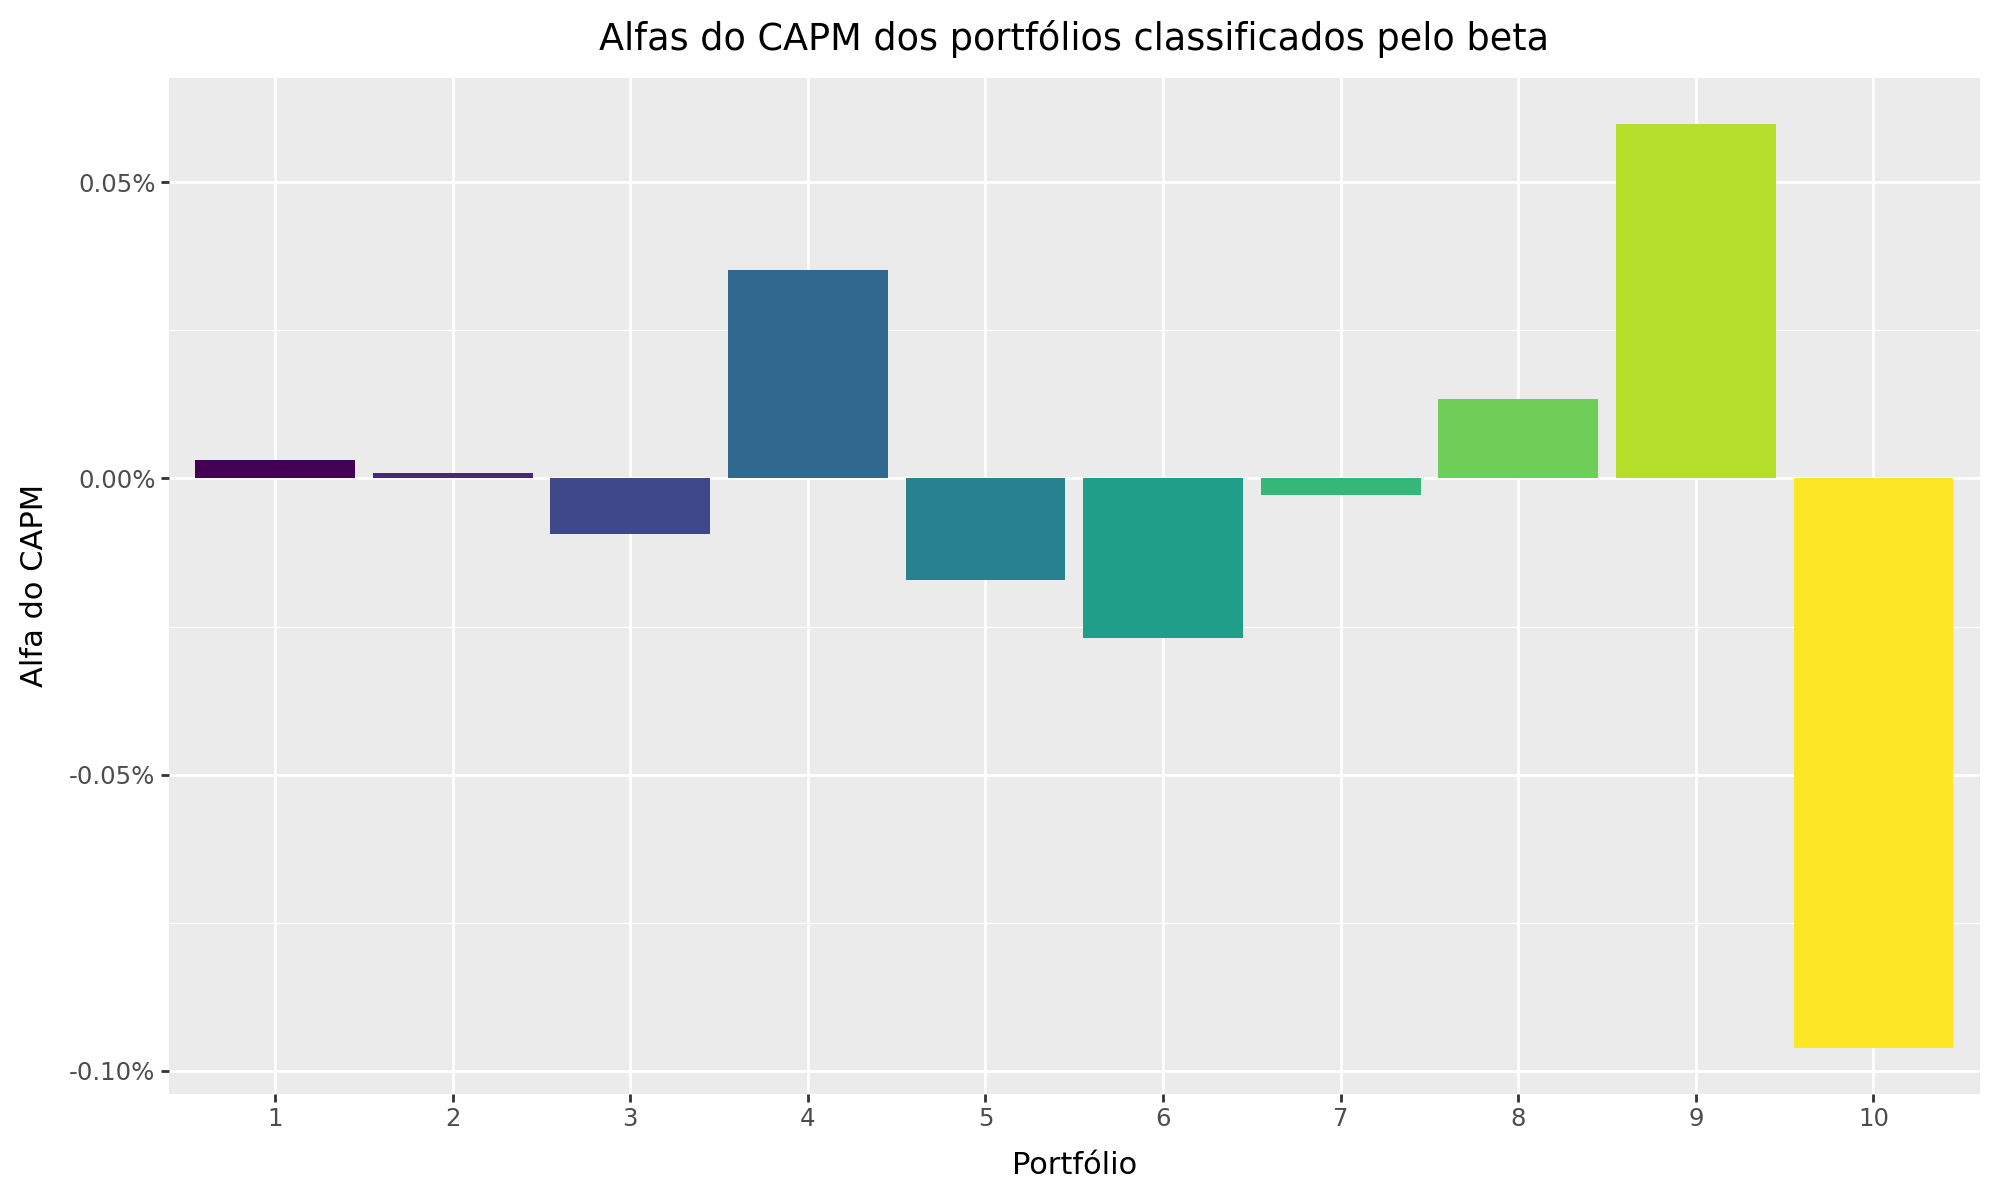

In [ ]:
# Sumariza os portfólios
plot_beta_portfolios_summary = (
  ggplot(beta_portfolios_summary,                # DataFrame contendo o resumo dos alphas, betas e retornos de cada portfólio
         aes(x="portfolio", y="alpha", fill="portfolio")) +  # Define as variáveis para o eixo x (portfolio), y (alpha) e a cor (portfolio)
  geom_bar(stat="identity") +                   # Adiciona um gráfico de barras com base nos valores dados
  labs(title="Alfas do CAPM dos portfólios classificados pelo beta",  # Adiciona título e rótulos aos eixos x, y e à legenda de cores
       x="Portfólio", y="Alfa do CAPM", fill="Portfólio") +
  scale_y_continuous(labels=percent_format()) +  # Formata os rótulos do eixo y como percentuais
  theme(legend_position="none", figure_size=(10, 6))  # Remove a legenda
)

plot_beta_portfolios_summary

## 5.3 Visualização: Security Market Line dos Portfólios Classificados

O CAPM prevê que nossos portfólios deveriam estar na linha do mercado de títulos (SML). A inclinação da SML é igual ao prêmio de risco de mercado e reflete o trade-off entre risco e retorno em qualquer momento específico. O gráfico abaixo ilustra a linha do mercado de títulos: Observamos que a SML é negativa, bem como há alta dispersão dos Retornos em relação ao Beta indicando que não há nenhuma relação bem definida dos Betas para o mercado acionário estudado.

/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


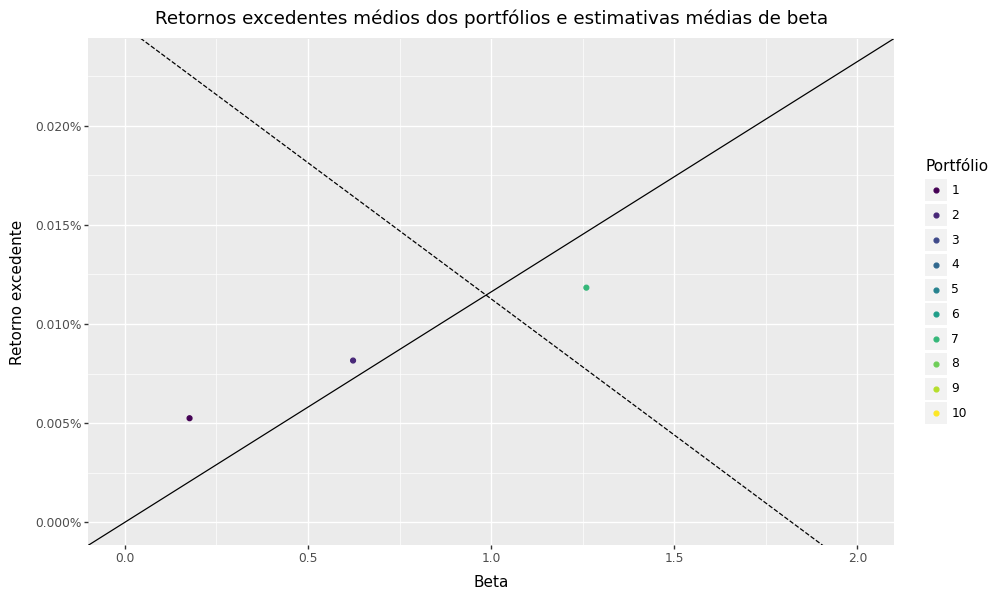

In [ ]:
# Cria a Security Market Line do Período
sml_capm = (
  sm.OLS.from_formula(
    formula="ret ~ 1 + beta",                   # Fórmula da regressão linear para a Security Market Line (SML)
    data=beta_portfolios_summary                 # DataFrame contendo o resumo dos alfas, betas e retornos de cada portfólio
  )
  .fit()
  .params
)

# Cria e exibe o gráfico da Security Market Line
plot_sml_capm = (
  ggplot(beta_portfolios_summary,
         aes(x="beta", y="ret", color="portfolio")) +  # Define as variáveis para o eixo x (beta), y (ret) e a cor (portfolio)
  geom_point() +                               # Adiciona pontos ao gráfico
  geom_abline(intercept=0,
              slope=beta_lag["market"].mean(),
              linetype="solid") +               # Adiciona uma linha sólida representando a média dos betas de mercado
  geom_abline(intercept=sml_capm["Intercept"],
              slope=sml_capm["beta"],
              linetype="dashed") +              # Adiciona uma linha tracejada representando a SML do período
  scale_y_continuous(
    labels=percent_format(),
    limits=(0, beta_lag["market"].mean()*2)
  ) +                                         # Formata os rótulos do eixo y como percentuais e define os limites
  scale_x_continuous(limits=(0, 2)) +          # Define os limites do eixo x
  labs(x="Beta", y="Retorno excedente", color="Portfólio",  # Adiciona rótulos aos eixos x, y e à legenda de cores
       title=("Retornos excedentes médios dos portfólios e "
              "estimativas médias de beta")) +
  theme(figure_size=(10, 6))
)
plot_sml_capm.draw()
